In [38]:
# import necessary libraries

import argparse
import cv2
import numpy as np
import imutils 
import time
import os

In [39]:
# read sample input image and make some operations on it.

start = time.time()
SET_WIDTH=int(600)

normalize_image =1/255.0
resize_image_shape = (1024,512)

sample_img= cv2.imread("./images/example_04q.png")
sample_img = imutils.resize(sample_img,width=SET_WIDTH)

blob_img = cv2.dnn.blobFromImage(sample_img,normalize_image,resize_image_shape,mean=0,swapRB=True,crop=False)

In [40]:
# loading our serialized ENET model from disk
print("[INFO] loading model...")
cv2_enet_model =cv2.dnn.readNet("./enet-cityscapes/enet-model.net")

[INFO] loading model...


In [41]:
# performing a forward pass using the segmentation model

cv2_enet_model.setInput(blob_img)
cv2_enet_model_output=cv2_enet_model.forward()


In [42]:
cv2_enet_model_output

array([[[[ 16.23959   ,  15.522214  ,  16.307596  , ...,  13.646136  ,
           16.99088   ,  16.332756  ],
         [ 14.385656  ,  13.669519  ,  15.150527  , ...,  12.517865  ,
           15.542568  ,  14.916639  ],
         [ 14.082906  ,  13.469954  ,  14.191579  , ...,   9.165161  ,
           14.763374  ,  14.317944  ],
         ...,
         [ 11.510036  ,  11.055325  ,   8.759819  , ...,   6.2956038 ,
           12.3906145 ,  12.036193  ],
         [ 15.993241  ,  15.461727  ,  15.117961  , ...,  12.751856  ,
           16.010235  ,  15.50335   ],
         [ 14.539336  ,  13.985912  ,  13.613315  , ...,  11.929541  ,
           15.058089  ,  14.554626  ]],

        [[  0.21112427,   0.20578459,  -2.581048  , ...,  -2.5306525 ,
           -0.5316927 ,  -0.61392176],
         [ -1.9537966 ,  -1.948885  ,  -4.6547775 , ...,  -4.56764   ,
           -2.9814382 ,  -3.1215892 ],
         [ -0.6301715 ,  -0.5589757 ,  -3.1590295 , ...,  -4.251284  ,
           -2.1547227 ,  -2.25216

In [43]:
# loading the class name labels

label_values = open(
    "./enet-cityscapes/enet-classes.txt").read().strip().split("\n")

In [44]:
# Interferring the shape of the total number of classes, along with the spatial dimensions of the mask image

IMG_OUTPUT_SHAPE_START =1
IMG_OUTPUT_SHAPE_END= 4
(classes_num,h,w)=cv2_enet_model_output.shape[
    IMG_OUTPUT_SHAPE_START:IMG_OUTPUT_SHAPE_END
]

In [45]:
# finding highest probability of clas label for each pixels
class_map = np.argmax(cv2_enet_model_output[0],axis=0)

In [46]:
# we can determine object color randomly or we can determine a txt file from disk
if os.path.isfile("./enet-cityspaces/enet-colors.txt"):
    CV_ENET_SHAPE_IMG_COLORS=open("./enet-cityspaces/enet-colors.txt").read().strip().split("\n")
    CV_ENET_SHAPE_IMG_COLORS=[
        np.array(c.split(",")).astype("int") for c in CV_ENET_SHAPE_IMG_COLORS
    ]
    CV_ENET_SHAPE_IMG_COLORS=np.array(CV_ENET_SHAPE_IMG_COLORS,dtype="uint8")

else:
    np.random.seed(42)
    CV_ENET_SHAPE_IMG_COLORS=np.random.randint(0,255,size=(len(label_values) -1,3),dtype="uint8")
    CV_ENET_SHAPE_IMG_COLORS=np.vstack([[0,0,0],CV_ENET_SHAPE_IMG_COLORS]).astype("uint8")
    

In [47]:
# mapping each class ID with the given class ID
mask_class_map= CV_ENET_SHAPE_IMG_COLORS[class_map]


# resize the mask and class map in such a way that its dimensions match the original size of the input image

mask_class_map=cv2.resize(mask_class_map,(sample_img.shape[1],sample_img.shape[0]),
                          interpolation=cv2.INTER_NEAREST)
class_map=cv2.resize(class_map,(sample_img.shape[1],sample_img.shape[0]),
                     interpolation=cv2.INTER_NEAREST)


In [48]:
"""""
We create a visualized output by applying a weighted mask to an image,
where the sum of weights (e.g., 0.4 and 0.6) equals 1 to maintain intensity.
Masks with negative weights can generate negative pixel values, adjusting
the image's contrast or intensity.
"""""
cv2_enet_model_output=((0.4*sample_img)+(0.6*mask_class_map)).astype("uint8")


In [49]:
# initializing the legend's visualization
my_legend= np.zeros(((len(label_values)*25)+25,300,3),dtype="uint8")


In [50]:
for(i,(class_name,img_color)) in enumerate(zip(label_values,CV_ENET_SHAPE_IMG_COLORS)):
    #draw the classname + color on the legend
    color_info=[int(color) for color in img_color]
    cv2.putText(my_legend,class_name,(5,(i*25)+17),
                cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.5,color=(0,0,255),thickness=2)
    cv2.rectangle(my_legend,(100,(i*25)),(300,(i*25)+25),tuple(color_info),-1)

In [51]:
# Showing the input and output image
cv2.imshow("My legend",my_legend)
cv2.imshow("Img_Input",sample_img)
cv2.imshow("CV_Model_Output",cv2_enet_model_output)
cv2.waitKey(0)
end=time.time()
cv2.destroyAllWindows()

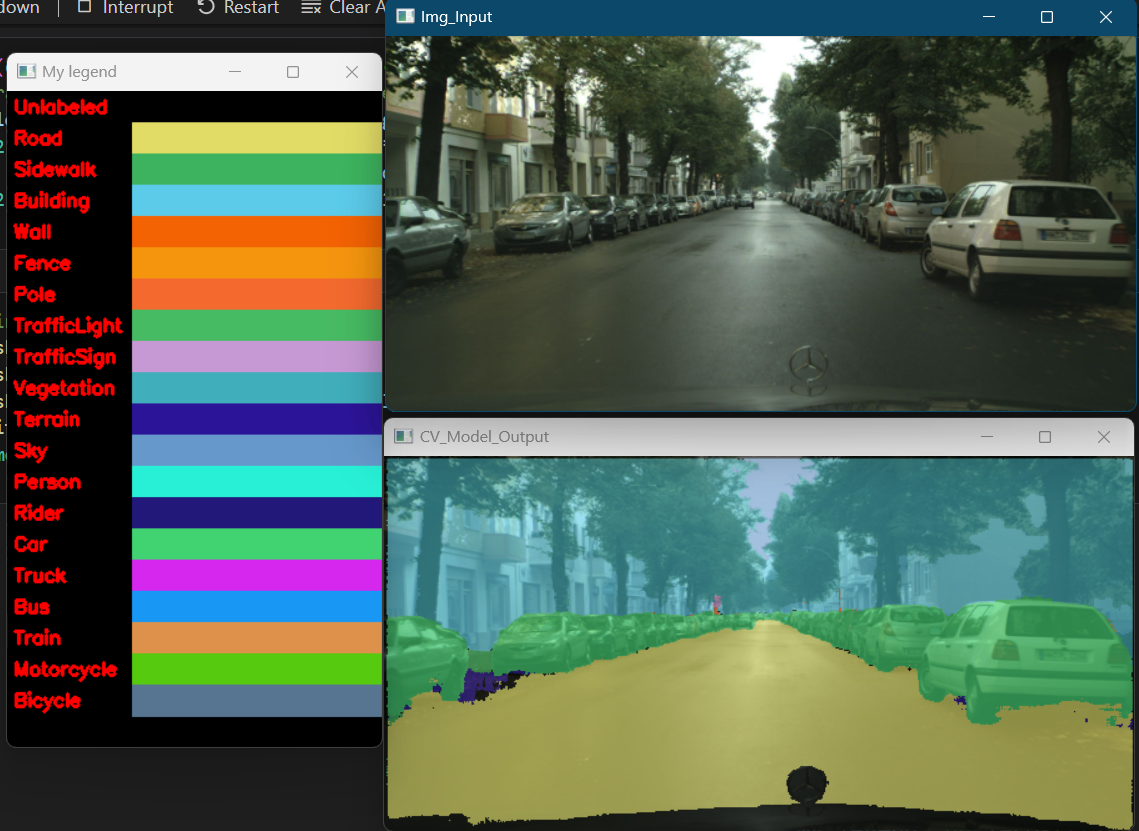

Semantic Segmentation in videos

In [52]:
import os 
import time
import cv2
import imutils
import numpy as np
DEFAULT_FRAME=1
WIDTH=600

class_labels = open('./enet-cityscapes/enet-classes.txt').read().strip().split("\n")

if os.path.isfile('./enet-cityscapes/enet-colors.txt'):
    CV_ENET_SHAPE_IMG_COLORS = open('./enet-cityscapes/enet-colors.txt').read().strip().split("\n")
    CV_ENET_SHAPE_IMG_COLORS = [np.array(c.split(",")).astype("int") for c in CV_ENET_SHAPE_IMG_COLORS]
    CV_ENET_SHAPE_IMG_COLORS = np.array(CV_ENET_SHAPE_IMG_COLORS, dtype="uint8")

else:
    
    np.random.seed(42)
    CV_ENET_SHAPE_IMG_COLORS = np.random.randint(0, 255, size=(len(class_labels) - 1, 3),
                               dtype="uint8")
    CV_ENET_SHAPE_IMG_COLORS = np.vstack([[0, 0, 0], CV_ENET_SHAPE_IMG_COLORS]).astype("uint8")

print("[INFO] loading model...")
cv_enet_model = cv2.dnn.readNet('./enet-cityscapes/enet-model.net')

sv = cv2.VideoCapture('./videos/video.mp4')
sample_video_writer = None

print(sv)

prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT

total = int(sv.get(prop))

# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(sv.get(prop))
    print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1
#sample_video
# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = sv.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # construct a blob from the frame and perform a forward pass
    # using the segmentation model
    normalize_image = 1 / 255.0
    resize_image_shape = (1024, 512)
    video_frame = imutils.resize(frame, width=SET_WIDTH)
    blob_img = cv2.dnn.blobFromImage(frame,  normalize_image,resize_image_shape, 0,
                                 swapRB=True, crop=False)
    cv_enet_model.setInput(blob_img)
    start = time.time()
    cv_enet_model_output = cv_enet_model.forward()
    end = time.time()

    # infer the total number of classes along with the spatial
    # dimensions of the mask image via the shape of the output array
    (Classes_num, height, width) = cv_enet_model_output.shape[1:4]

    # our output class ID map will be num_classes x height x width in
    # size, so we take the argmax to find the class label with the
    # largest probability for each and every (x, y)-coordinate in the
    # image
    classMap = np.argmax(cv_enet_model_output[0], axis=0)

    # given the class ID map, we can map each of the class IDs to its
    # corresponding color
    
    mask_class_map = CV_ENET_SHAPE_IMG_COLORS[classMap]

    # resize the mask such that its dimensions match the original size
    # of the input frame
    
    
    mask_class_map = cv2.resize(mask_class_map, (video_frame.shape[1], video_frame.shape[0]),
                      interpolation=cv2.INTER_NEAREST)

    # perform a weighted combination of the input frame with the mask
    # to form an output visualization
    
    
    cv_enet_model_output = ((0.3 * video_frame) + (0.7 * mask_class_map)).astype("uint8")

    # check if the video writer is None
    if sample_video_writer is None:
        print("sample_video_writer is None")
        # initialize our video writer
        fourcc_obj = cv2.VideoWriter_fourcc(*"MJPG")

        sample_video_writer = cv2.VideoWriter('./output/output_toronoto.avi', fourcc_obj, 30,
                                 (cv_enet_model_output.shape[1], cv_enet_model_output.shape[0]), True)

        # some information on processing single frame
        if total > 0:
            
            execution_time = (end - start)
            print("[INFO] single video_frame took {:.4f} seconds".format(execution_time))

            print("[INFO] estimated total_time time: {:.4f}".format(
                execution_time * total))

    # write the output frame to disk
    
    sample_video_writer.write(cv_enet_model_output)

    # check to see if we should display the output frame to our screen
    if DEFAULT_FRAME > 0:
        cv2.imshow("Video Frame", cv_enet_model_output)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord("q"):
            break

print("[INFO] cleaning up...")
sample_video_writer.release()
sv.release()
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] loading model...
< cv2.VideoCapture 0000016FC3CC5090>
[INFO] 1007 total frames in video
sample_video_writer is None
[INFO] single video_frame took 0.3522 seconds
[INFO] estimated total_time time: 354.6806
[INFO] cleaning up...
